In [1]:
import sys
import IPython.display
import numpy
import matplotlib.pyplot
import matplotlib.collections
import fzreader

In [2]:
def plot_camera(data, ax=None):
    camera = fzreader.get_camera_geometry_by_nadc(len(data))
    npix = camera['npix']
    scale = max(data[0:npix])
    x = numpy.asarray(camera['x'])
    y = numpy.asarray(camera['y'])
    r = numpy.asarray(camera['r'])

    if(ax is None):
        fig, ax = matplotlib.pyplot.subplots(dpi=150)

    edge_patches = []
    face_patches = []
    for i in range(npix):
        edge_patches.append(matplotlib.pyplot.Circle((x[i],y[i]), r[i]))
        face_patches.append(matplotlib.pyplot.Circle((x[i],y[i]), r[i]*max(data[i],0)/scale))
    
    patch_collection = matplotlib.collections.PatchCollection(face_patches)
    patch_collection.set_facecolor('b')
    patch_collection.set_linewidth(0)
    ax.add_collection(patch_collection)

    patch_collection = matplotlib.collections.PatchCollection(edge_patches, alpha=0.4)
    patch_collection.set_edgecolor('k')
    patch_collection.set_facecolor('none')
    patch_collection.set_linewidth(0.5)
    ax.add_collection(patch_collection)

    xylim = max([max(abs(x+r)),max(abs(x-r)),max(abs(y+r)),max(abs(y-r))])*1.1
    ax.set_xlim([-xylim,xylim])
    ax.set_ylim([-xylim,xylim])
    ax.set_box_aspect(1)

    return ax

# Download data from archive

As of September 2025 the Whipple data is available publicly. The data files can be downloaded on-the-fly through the reader.

In [3]:
archive = fzreader.FZDataArchive('zenodo', verbose=True) # can also choose 'harvard'
fzdata = archive.get_run_by_number(13167)

[FZDataArchive] Downloading index.json from https://zenodo.org/records/16890876/files/index.json?download=1
[FZDataArchive] Downloading raw10_index.csv.xz from https://zenodo.org/records/16890876/files/raw10_index.csv.xz?download=1
Archive: Raw data from the Whipple 10m gamma-ray telescope, Mt Hopkins, AZ
Provider: Zenodo (10.5281/zenodo.16890876) | Runs: 22772 files / 186.51 GB
[FZDataArchive] Fetching raw10/d19990622/gt013167.fz.xz from raw10_1998_1999.tar [16683094528-16711098487]


# Calculate pedestals

Loop through all records in the FZ file and extract the pedestal events. To support data files with `gdf_version<74` we must handle both `event` and `pedestal` record types. Loop through all records looking for those with `record_type in ('event', 'frame')` with `record_was_decoded==True` and `event_type=='pedestal'`. Count all such events in `nped` and sum the charges from the 490 ADCs in `ped_sum` and the square if the charges in `ped_sum_sq`.

We can then calculate the pedestal value and its RMS.

In [4]:
nped = 0
ped_sum = 0
ped_sum_sq = 0
source_name = 'unknown'
with fzreader.FZReader(fzdata,verbose=False) as fz:
    for record in fz:
        if(record['record_type'] == 'tracking'):
            source_name = record['target']
        if(record['record_type'] in ('event','frame') and record['record_was_decoded'] and record['event_type'] == 'pedestal'):
            nped += 1
            adc_values = numpy.asarray(record['adc_values'], dtype=float)
            ped_sum = numpy.add(adc_values, ped_sum)
            ped_sum_sq = numpy.add(adc_values ** 2, ped_sum_sq)

In [5]:
ped_val = ped_sum/nped
ped_rms = numpy.sqrt(ped_sum_sq/nped - ped_val**2)

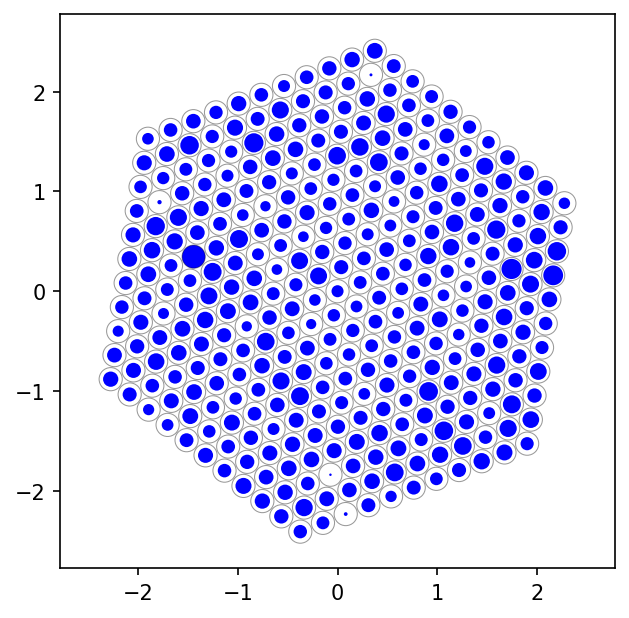

In [6]:
plot_camera(ped_rms);
# matplotlib.pyplot.axis('square')

# Plot events

Loop through all records in the FZ file and extract those with `record_type==event`. Plot the signal in each pixel (ADC value minus pedestal). Here we filter events that have more than 20 channels having more than 16DC per channel, to preferentiall display muon rings.

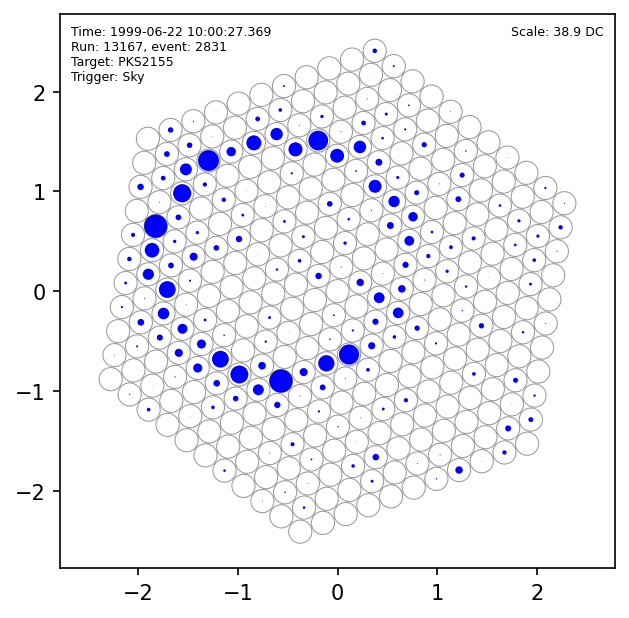

In [7]:
with fzreader.FZReader(fzdata, verbose=False) as fz:
    fig = matplotlib.figure.Figure(dpi=150)
    ax = fig.subplots(1,1)
    try:
        for record in fz:
            if(record['record_type'] == 'event' and record['event_type'] == 'sky'):
                adc_values = numpy.asarray(record['adc_values'], dtype=float)
                signal = (adc_values-ped_val)
                if(numpy.count_nonzero(signal>16)<20):
                    continue
                IPython.display.clear_output(wait=True)
                ax.clear()
                ax = plot_camera(signal, ax=ax)
                xylim = ax.get_xlim()[1] / 1.04
                ax.text(-xylim,xylim,f"Time: {record['record_time_str']}\nRun: {record['run_num']}, event: {record['event_num']}\nTarget: {source_name}\nTrigger: {record['event_type'].capitalize()}",
                    fontsize=6,ha='left',va='top')
                ax.text(xylim,xylim,f"Scale: {max(signal):.1f} DC",fontsize=6,ha='right',va='top')
                IPython.display.display(fig)
                fig.canvas.draw()
                matplotlib.pyplot.pause(0.5)
                if(record['event_num'] == 2831):
                    break
    except KeyboardInterrupt:
        matplotlib.pyplot.show()